In [92]:
import sys
sys.path.append("..")

In [93]:
import numpy as np
import os
import pathlib
import scipy.linalg
import scipy.interpolate
import meshio
import gmsh
import matplotlib.pyplot as plt
import pytictoc

from femns2d import femns2d

In [94]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
def create_unit_square_mesh(pfactor=0.1, name="unit_square.msh"):
    gmsh.initialize()
    gmsh.model.add('unit_square')
    
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, 0, 0, pfactor, 1)
    gmsh.model.geo.addPoint(1, 0, 0, pfactor, 2)
    gmsh.model.geo.addPoint(1, 1, 0, pfactor, 3)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 4)

    # Connect points with lines to form unit square
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)

    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1], 1)
    gmsh.model.geo.addPhysicalGroup(1, [2], 2)
    gmsh.model.geo.addPhysicalGroup(1, [3], 3)
    gmsh.model.geo.addPhysicalGroup(1, [4], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('unit_square.msh')

    gmsh.finalize()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000470409s, CPU 0.000744s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00549795s, CPU 0.00589s)
Info    : 142 nodes 286 elements
Info    : Writing 'unit_square.msh'...
Info    : Done writing 'unit_square.msh'



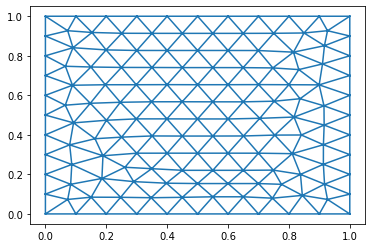

In [96]:
# Read the mesh file
create_unit_square_mesh(0.1)
mesh = meshio.read("unit_square.msh")

# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

In [97]:
D_ferrite = 6*1e-11
D_austenite = 1.4*1e-16
s_ferrite = 0.033
s_austenite = 32.51

#alpha ferrite, beta austenite, normalize over ferrite
s_alpha = 1.0
D_alpha = 1.0
D_beta = D_austenite/D_ferrite
s_beta = s_austenite/s_ferrite
Ds_alpha = 1.0
Ds_beta = D_beta*s_beta
reference_length = 1000*1e-6
reference_time = (reference_length**2)/D_ferrite

In [108]:
def diffusion_and_mass_functions(xy):
    x = xy[..., 0]
    y = xy[..., 1]
    condition = (x > 0.25) & (x < 0.75) & (y > 0.25) & (y < 0.75)
    diff = Ds_beta*condition + 1.0*(1-condition)
    mass = s_beta*condition + 1.0*(1-condition)
    return diff, mass
assembler = femns2d.MiniAssembler(mesh)
element_diffusions, element_masses = diffusion_and_mass_functions(assembler.centroids)

In [133]:
dt0 = 0.03
increasing_factor = 1 + 0*1e-3
increasing_frequency = steps + 2
steps = 10000
dirichlet_bcs = [[1], [3]]
increasing_factor**(steps/increasing_frequency)

1.0

In [134]:
assembler = femns2d.MiniAssembler(mesh)
assembler.set_main_element("linear")
K = assembler.stiffness_matrix(stiffness_fn=lambda i : element_diffusions[i],
                               stiffness_fn_type='element')
M = assembler.mass_matrix(mass_fn=lambda i : element_masses[i], mass_fn_type='element')
mu = np.zeros(assembler.npoints)
mu = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, mu, where='u')
t = 0.0
dt = dt0/increasing_factor
mu_list = [mu.copy()]
t_list = [t]
for step in range(steps):
    if step%increasing_frequency == 0:
        dt *= increasing_factor
        A = M/dt + K
        A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs[1], A, where='u')
    t = t + dt
    f = M/dt@mu
    f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs, f, where='u')
    mu = scipy.sparse.linalg.spsolve(A.tocsc(), f)
    mu_list.append(mu.copy())
    t_list.append(t)
#     dt *= increasing_factor
    if step%200 == 0:
        print(step)

0
200
400
600
800
1000
1200
1400
1600
1800
2000
2200
2400
2600
2800
3000
3200
3400
3600
3800
4000
4200
4400
4600
4800
5000
5200
5400
5600
5800
6000
6200
6400
6600
6800
7000
7200
7400
7600
7800
8000
8200
8400
8600
8800
9000
9200
9400
9600
9800


In [135]:
assembler.set_boundary_vectors()

In [136]:
def calculate_boundary_concentration(mu):
    boundary_markers = mesh.cell_data_dict["gmsh:physical"]["line"]
    lower_boundary_indexes = boundary_markers == 1
    boundary_elements = assembler.boundary_element_map[lower_boundary_indexes]
    boundary_centroids_mu = assembler.get_centroid_values_from_linear(mu)[boundary_elements]
    boundary_concentrations = element_masses[boundary_elements]*\
                              boundary_centroids_mu
    boundary_concentrations = (boundary_concentrations*assembler.boundary_lengths[lower_boundary_indexes]).sum()
    return boundary_concentrations

def calculate_boundary_fluxes(mu):
    gradmu = assembler.get_linear_element_equation(mu)[:, :-1]
    boundary_markers = mesh.cell_data_dict["gmsh:physical"]["line"]
    lower_boundary_indexes = boundary_markers == 1
    boundary_elements = assembler.boundary_element_map[lower_boundary_indexes]
    boundary_gradmu = gradmu[boundary_elements]
    boundary_normals = assembler.boundary_normals[lower_boundary_indexes]
    boundary_fluxes = -element_diffusions[boundary_elements]*element_masses[boundary_elements]*\
                              (boundary_gradmu*boundary_normals).sum(axis=-1)
    boundary_fluxes = (boundary_fluxes*assembler.boundary_lengths[lower_boundary_indexes]).sum()
    return boundary_fluxes


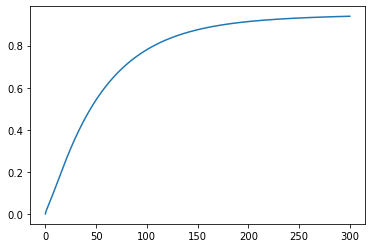

In [137]:
if len(dirichlet_bcs[1]) == 1:
    concentrations = np.hstack([calculate_boundary_concentration(mu) for mu in mu_list])
    time = np.array(t_list)
    plt.plot(time, concentrations)
elif len(dirichlet_bcs[1]) == 2:
    fluxes = np.hstack([calculate_boundary_fluxes(mu) for mu in mu_list])
    time = np.arange(len(mu_list))*dt
    plt.plot(time, fluxes)


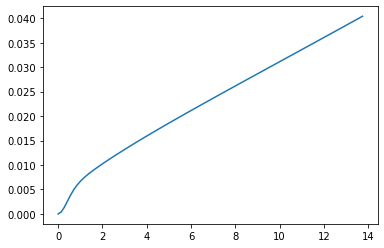

In [139]:
time_hours = time*reference_time/3600 #h
# plt.plot(time_hours[:1000], fluxes[:500])
plt.plot(time_hours[:100], concentrations[:100])
# plt.semilogx()
# plt.figure()
# integral = np.diff(time)*np.cumsum(concentrations)[:-1]
# time_integral = (time[1:] + time[:-1])/2
# plt.plot(time_integral, integral)

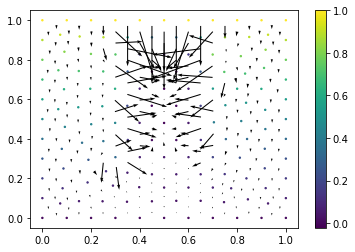

In [105]:
frame = 10000
mu = mu_list[frame]
gradmu = assembler.get_linear_element_equation(mu)[:, :-1]
diff = (element_diffusions*element_masses)[..., None]*gradmu
x, y = assembler.points[:, 0], assembler.points[:, 1]
plt.scatter(x, y, c=mu, s=2)
plt.colorbar()
xe, ye = assembler.centroids[..., 0], assembler.centroids[..., 1]
plt.quiver(xe, ye, -diff[..., 0], -diff[..., 1])

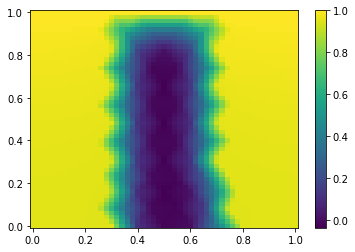

In [68]:
frame = 10000
mu = mu_list[frame]
mu_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], mu)

ngrid = 51
xplot, yplot = np.linspace(0, 1, ngrid), np.linspace(0, 1, ngrid)
Xplot, Yplot = np.meshgrid(xplot, yplot)
Mu = mu_interp(Xplot, Yplot)
plt.pcolormesh(Xplot, Yplot, Mu, shading='auto')
plt.colorbar()